🚀 STEP 5: Probabilistic Ensemble Evaluation START
📊 merged data shape: (525165, 45)

📊 [참고] 모델 성능 요약 (STEP 1~2 결과)

- 구조적 단절 위험 모델        : Test AUC ≈ 0.81
- 개인 취업확률 모델 (Calibrated): Test AUC ≈ 0.87

※ 본 STEP에서는 분류 성능을 재계산하지 않음
※ 이후 평가는 확률 품질 중심


📊 확률 예측 품질 지표
Brier Score : 0.1131
Log Loss    : 0.3715


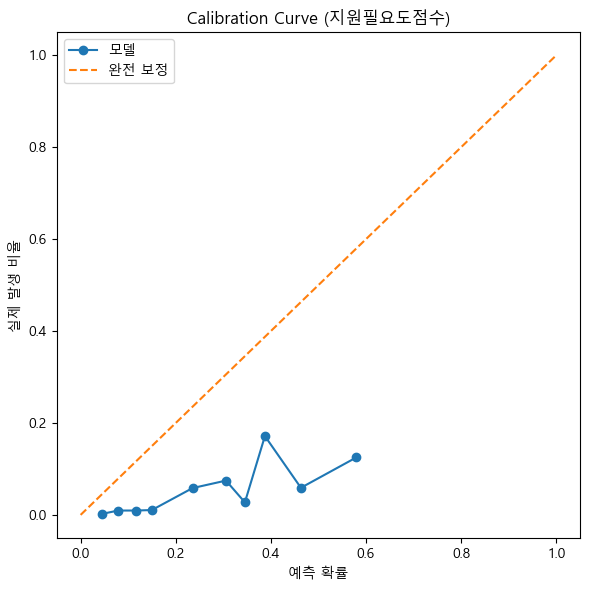


📊 집중 타겟팅 성능 (지원필요도점수 기준)
  타겟 구간   대상 인원 Top-K 진성 쉬었음 비율 전체 평균  Lift
Top 30% 157,549          11.78% 5.50% 2.14배
Top 20% 105,033           9.18% 5.50% 1.67배
Top 10%  52,516          12.49% 5.50% 2.27배

💾 결과 저장 완료
📁 ../results/final/step5_probabilistic_evaluation.csv
🎉 STEP 5 COMPLETE (PROBABILISTIC ONLY)


In [ ]:
# ======================================================
# STEP 5: Probabilistic Ensemble Evaluation (NO classification)
# ------------------------------------------------------
# ✔ 정확도 / threshold 기반 지표 완전 제거
# ✔ 이미 계산된 "확률 결과"만 사용
# ✔ 정책 친화적 평가 지표만 사용
#   - Calibration Curve
#   - Brier Score
#   - Log Loss
#   - Lift (Top-k)
# ======================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss, log_loss
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------
# 한글 폰트 설정
# ------------------------------------------------------
from matplotlib import font_manager, rc
import platform

if platform.system() == "Windows":
    path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)

elif platform.system() == "Darwin":
    path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)

elif platform.system() == "Linux":
    path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)

# ------------------------------------------------------
# START
# ------------------------------------------------------
print("=" * 70)
print("🚀 STEP 5: Probabilistic Ensemble Evaluation START")
print("=" * 70)

# ------------------------------------------------------
# 1️⃣ 입력: 이미 병합된 결과
# ------------------------------------------------------
PATH = "../results/final/merged_policy_analysis.csv"
df = pd.read_csv(PATH)

print(f"📊 merged data shape: {df.shape}")

# 필수 컬럼 체크
TARGET_COL = "진성쉬었음"
PROB_COL   = "지원필요도점수"

for col in [TARGET_COL, PROB_COL]:
    if col not in df.columns:
        raise ValueError(f"❌ 필수 컬럼 누락: {col}")

# ------------------------------------------------------
# 2️⃣ 참고용 성능 요약 (재계산 ❌)
# ------------------------------------------------------
print("\n📊 [참고] 모델 성능 요약 (STEP 1~2 결과)")
print("""
- 구조적 단절 위험 모델        : Test AUC ≈ 0.81
- 개인 취업확률 모델 (Calibrated): Test AUC ≈ 0.87

※ 본 STEP에서는 분류 성능을 재계산하지 않음
※ 이후 평가는 확률 품질 중심
""")

# ------------------------------------------------------
# 3️⃣ 확률 예측 품질 평가
#    (Brier / LogLoss)
# ------------------------------------------------------
y_true = np.asarray(df[TARGET_COL], dtype=float)
y_prob = np.asarray(df[PROB_COL], dtype=float)

# 수치 안정성 확보
eps = 1e-15
y_prob = np.clip(y_prob, eps, 1 - eps)

brier = brier_score_loss(y_true, y_prob)
lloss  = log_loss(y_true, y_prob)

print("\n📊 확률 예측 품질 지표")
print(f"Brier Score : {brier:.4f}")
print(f"Log Loss    : {lloss:.4f}")

# ------------------------------------------------------
# 4️⃣ Calibration Curve
# ------------------------------------------------------
prob_true, prob_pred = calibration_curve(
    y_true,
    y_prob,
    n_bins=10,
    strategy="quantile"
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="모델")
plt.plot([0, 1], [0, 1], linestyle="--", label="완전 보정")
plt.xlabel("예측 확률")
plt.ylabel("실제 발생 비율")
plt.title("Calibration Curve (지원필요도점수)")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 5️⃣ 집중 타겟팅 성능 (Lift, Top-K)
# ------------------------------------------------------
print("\n📊 집중 타겟팅 성능 (지원필요도점수 기준)")

base_rate = y_true.mean()
total_n = len(df)

rows = []

for k in [0.30, 0.20, 0.10]:
    n = int(total_n * k)

    top = df.sort_values(
        PROB_COL, ascending=False
    ).head(n)

    top_rate = top[TARGET_COL].mean()
    lift = top_rate / base_rate if base_rate > 0 else 0

    rows.append({
        "타겟 구간": f"Top {int(k*100)}%",
        "대상 인원": f"{n:,}",
        "Top-K 진성 쉬었음 비율": f"{top_rate*100:.2f}%",
        "전체 평균": f"{base_rate*100:.2f}%",
        "Lift": f"{lift:.2f}배"
    })

table_target = pd.DataFrame(rows)
print(table_target.to_string(index=False))

# ------------------------------------------------------
# 6️⃣ 결과 저장 (보고서용)
# ------------------------------------------------------
OUT_PATH = "../results/final/step5_probabilistic_evaluation.csv"
table_target.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")

print("\n💾 결과 저장 완료")
print(f"📁 {OUT_PATH}")

print("=" * 70)
print("🎉 STEP 5 COMPLETE (PROBABILISTIC ONLY)")
print("=" * 70)
